# Astro M33

Here we explore ways of finding the age of the universe using spectra.

(TODO: complete this section)

## Setup

Do the imports and create the spark session instance.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Astro") \
    .enableHiveSupport() \
    .getOrCreate()

## Ingest

This function copies the astronomy data to managed tables. This will take some time (and disk space), but it only needs to be done once ever for the data, and it will speed up any future analysis. Any future runs of ingest() will be ignored (silently fail) due to the table already existing.

To re-ingest, one must first drop the tables.

### Spectra Data

(TODO: complete this section)

### Absorption Data

Details the wavelength ranges in the spectrum in which named absorption lines exist. (TODO: complete this section)

In [2]:
# Uncomment to delete the table if necessary
# spark.sql('drop table spectra')

In [3]:
# Uncomment to delete the table if necessary
# spark.sql('drop table absorption')

In [4]:
def split_fixed_width_col(column):
    return split(trim(column), ' +')

def filter_headers(raw_df):
    return raw_df.filter(~col('value').startswith('#'))

def ingest_spectra():
    if "spectra" in [t.name for t in spark.catalog.listTables("default")]:
        print('Table "spectra" already exists. Ignoring.')
        return
    raw = spark.read.text("../data/spectra/*/*/hmix.*")
    raw_filtered = filter_headers(raw)
    
    cleaned = raw_filtered \
        .select(
            split(input_file_name(), '/').alias('fn_split'),
            split_fixed_width_col(col('value')).alias('raw_split')) \
        .select(
            element_at(col('fn_split'), -3).alias('dataset'),
            element_at(col('fn_split'), -2).alias('cp_str'),
            element_at(col('fn_split'), -1).alias('fn'),
            col('raw_split')[0].cast('float').alias('wavelength'),
            col('raw_split')[1].cast('float').alias('flam')) \
        .select(
            col('dataset'),
            when(col('cp_str') == 'cp', 1).otherwise(0).alias('is_cp'),
            substring(col('fn'), 7, 6).cast('bigint').alias('age_mil'),
            substring(col('fn'), 14, 4).cast('int').alias('heavy_metal_c'),
            col('wavelength'),
            col('flam'))
    cleaned \
        .write \
        .mode('ignore') \
        .partitionBy(
            'dataset',
            'heavy_metal_c',
            'is_cp',
            'age_mil') \
        .bucketBy(8, 'wavelength') \
        .format('orc') \
        .saveAsTable('spectra')
    
def ingest_absorption():
    if "absorption" in [t.name for t in spark.catalog.listTables("default")]:
        print('Table "absorption" already exists. Ignoring.')
        return
    raw = spark.read.text("../data/absorption/index.table")
    raw_filtered = filter_headers(raw)
    cleaned = raw_filtered \
        .select(split_fixed_width_col(col('value')).alias('raw_split')) \
        .select(
                col('raw_split')[0].cast('int').alias('id'),
                col('raw_split')[1].cast('float').alias('index_band_min'),
                col('raw_split')[2].cast('float').alias('index_band_max'),
                col('raw_split')[3].cast('float').alias('blue_continuum_min'),
                col('raw_split')[4].cast('float').alias('blue_continuum_max'),
                col('raw_split')[5].cast('float').alias('red_continuum_min'),
                col('raw_split')[6].cast('float').alias('red_continuum_max'),
                col('raw_split')[7].cast('int').alias('units'),
                col('raw_split')[8].alias('name'))
    cleaned \
        .write \
        .mode('ignore') \
        .format('orc') \
        .saveAsTable('absorption')
    

In [5]:
ingest_spectra()

In [6]:
ingest_absorption()

## Let's take a look at the data in the tables...

### Spectra Table

In [7]:
spark.table('spectra').show()

+----------+--------+--------+-------------+-----+-------+
|wavelength|    flam| dataset|heavy_metal_c|is_cp|age_mil|
+----------+--------+--------+-------------+-----+-------+
|   3000.38|25314.78|m33_0.01|          790|    0|    100|
|   8859.64|2000.581|m33_0.01|          790|    0|    100|
|    3000.5|25166.85|m33_0.01|          790|    0|    100|
|   8859.85|1988.565|m33_0.01|          790|    0|    100|
|   3000.52| 25134.6|m33_0.01|          790|    0|    100|
|    8859.9|1988.374|m33_0.01|          790|    0|    100|
|   3000.58|25026.55|m33_0.01|          790|    0|    100|
|   8859.99|1989.904|m33_0.01|          790|    0|    100|
|   3000.76|24667.97|m33_0.01|          790|    0|    100|
|   8860.12|1994.742|m33_0.01|          790|    0|    100|
|   3000.83|24560.54|m33_0.01|          790|    0|    100|
|   8860.14|1995.604|m33_0.01|          790|    0|    100|
|   3001.01|24524.21|m33_0.01|          790|    0|    100|
|   8860.15|1996.036|m33_0.01|          790|    0|    10

### Spectra Schema Description
- `wavelength`: The wavelength of the spectrum
- `flam`: A measurement of flux (amount of energy at the corresponding wavelength)
- `dataset`: Where the data came from (m33_0.01 = metalicity 33)
- `heavy_metal_c`: The amount of heavy metal content
- `is_cp`: 0 or 1. 1 if chemically peculiar.
- `age_mil`: Age in millions of years of the galaxy in the dataset

### Absorption Table

In [8]:
spark.table('absorption').show()

+---+--------------+--------------+------------------+------------------+-----------------+-----------------+-----+-------+
| id|index_band_min|index_band_max|blue_continuum_min|blue_continuum_max|red_continuum_min|red_continuum_max|units|   name|
+---+--------------+--------------+------------------+------------------+-----------------+-----------------+-----+-------+
|  1|      4142.125|      4177.125|          4080.125|          4117.625|         4244.125|         4284.125|    1|   CN_1|
|  2|      4142.125|      4177.125|          4083.875|          4096.375|         4244.125|         4284.125|    1|   CN_2|
|  3|       4222.25|       4234.75|            4211.0|           4219.75|           4241.0|           4251.0|    0| Ca4227|
|  4|      4281.375|      4316.375|          4266.375|          4282.625|         4318.875|         4335.125|    0|  G4300|
|  5|      4369.125|      4420.375|          4359.125|          4370.375|         4442.875|         4455.375|    0| Fe4383|
|  6|   

### Absorption Schema Description
- `id`: The id of the absorption line
- `index_band_min`: The range start for the absorption line
- `index_band_max`: The range end for the absorption line
- `blue_continuum_min`: The range start for where the continuum line is measured from (blue = left side)
- `blue_continuum_max`: The range end for where the continuum line is measured from (blue = left side)
- `red_continuum_min`: The range start for where the continuum line is measured from (red = right side)
- `red_continuum_max`: The range end for where the continuum line is measured from (red = right side)
- `units`: N/A
- `name`: The standardized name of the absorption line

## Usage Tip: we can execute SQL statements like so to expore further...

In [9]:
spark.sql('SELECT * FROM spectra WHERE is_cp=1 AND age_mil=14 LIMIT 10').show()

+----------+--------+--------+-------------+-----+-------+
|wavelength|    flam| dataset|heavy_metal_c|is_cp|age_mil|
+----------+--------+--------+-------------+-----+-------+
|   3000.38|311351.3|m33_0.01|          790|    1|     14|
|   6578.86|16179.39|m33_0.01|          790|    1|     14|
|    3000.5|311013.9|m33_0.01|          790|    1|     14|
|    6579.0|16262.56|m33_0.01|          790|    1|     14|
|   3000.52|310993.6|m33_0.01|          790|    1|     14|
|   6579.04|16280.62|m33_0.01|          790|    1|     14|
|   3000.58|310997.0|m33_0.01|          790|    1|     14|
|    6579.1|16305.47|m33_0.01|          790|    1|     14|
|   3000.76|311354.0|m33_0.01|          790|    1|     14|
|   6579.11|16309.48|m33_0.01|          790|    1|     14|
+----------+--------+--------+-------------+-----+-------+



## Plotting spectra

A spectrum graph will plot the flux (flam, y-axis) against wavelength (x-axis).

### Picking a spectrum

Multiple spectra are in the main spectra table which is useful for finding patterns in the data, but it would be easier to focus on just a few of them for plotting purposes to get get an idea of what is in them. To plot a spectrum, we must first 'pick' one, ie. select the dataset, heavy metal content, and age of the spectrum we want to look at specifically.

### Sampling the data

This step is largely needed because Spark lacks plotting capability (as of 1/19/2021, although it does appear to be in the works). Copying all of the data output from a query would take a long time and cause an out-of-memory error, so we must sample before transferring to Pandas.

### Plotting the data

We use Pandas and Matplotlib to plot the sampled results. It's interesting to keep in mind how the spectra evolve as the age increases since the eventual goal will be to predict the age from unlabeled spectra.

In [11]:
def pick_spectrum(
    data_set='m33_0.01',
    heavy_metal_c=790,
    age_mil=11):
    
    table = spark.table('spectra')
    return table.filter(
        (col('dataset') == data_set) &
        (col('heavy_metal_c') == heavy_metal_c) &
        (col('age_mil') == age_mil))

def sample_spectrum(
    spectrum,
    wavelength_increment=10.0,
    min_wavelength=3000.0,
    max_wavelength=10000.0):

    bins = spectrum.select(
            (
                floor(
                    col('wavelength')/wavelength_increment
                )*wavelength_increment
            ).alias('wavelength'),
            col('is_cp'),
            col('flam')) \
        .filter(
            (col('wavelength') >= min_wavelength) &
                (col('wavelength') < max_wavelength)) \
        .groupBy(
            col('wavelength'),
            col('is_cp')) \
        .agg(avg(col('flam')).alias('avg_flam'))
    
    transf = bins.alias('b1') \
        .join(
            bins.alias('b2'),
            (col('b1.wavelength') == col('b2.wavelength')) &
                (col('b1.is_cp') == 0) &
                (col('b2.is_cp') == 1)) \
        .select(
            col('b1.wavelength').alias('wavelength'),
            col('b1.avg_flam').alias('flam_no_cp'),
            col('b2.avg_flam').alias('flam_cp')) \
        .orderBy(col('wavelength'))
    return transf
    
def plot_sampled_spectrum(sample_df, plot_title='Plot'):
    sampled_pdf = sample_df.toPandas().set_index('wavelength')
    sampled_pdf.plot.line(title=plot_title)
    
def sample_and_plot_spectrum(
    spectrum,
    num_samples=2000,
    min_wavelength=3000.0,
    max_wavelength=10000.0,
    plot_title='Plot'):
    
    wavelength_increment = (max_wavelength - min_wavelength)/num_samples
    sample = sample_spectrum(
        spectrum, 
        wavelength_increment=wavelength_increment, 
        min_wavelength=min_wavelength, 
        max_wavelength=max_wavelength)
    plot_sampled_spectrum(sample, plot_title=plot_title)
    

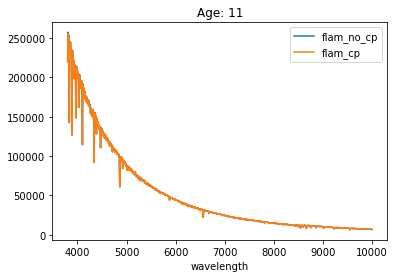

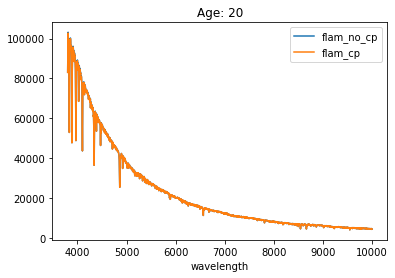

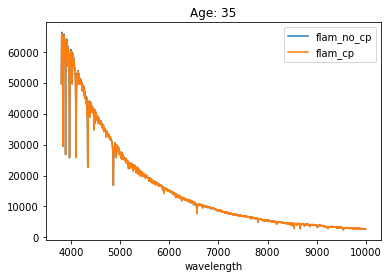

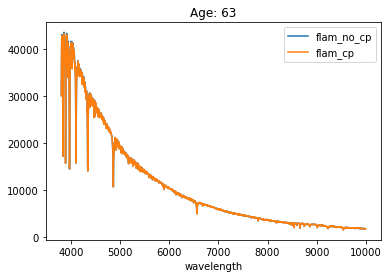

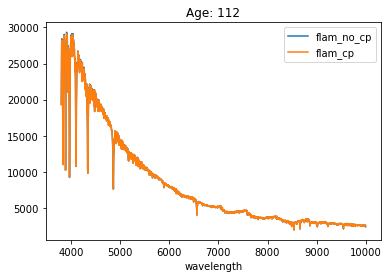

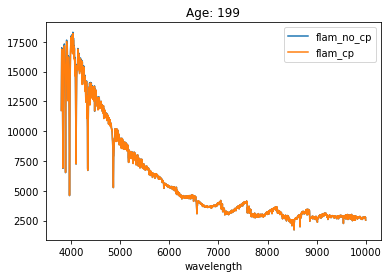

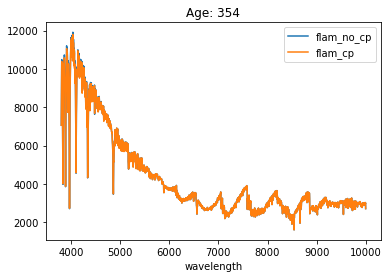

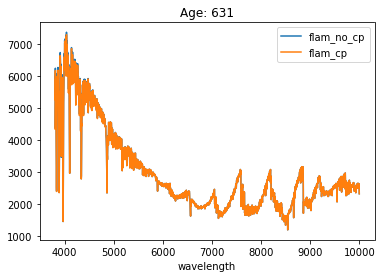

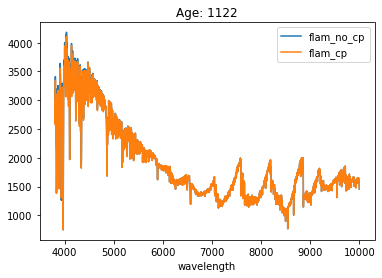

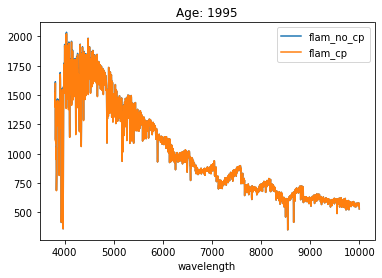

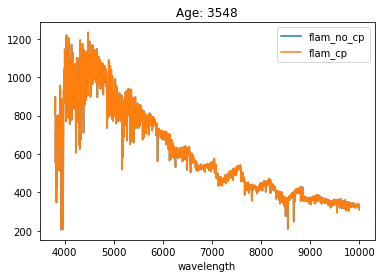

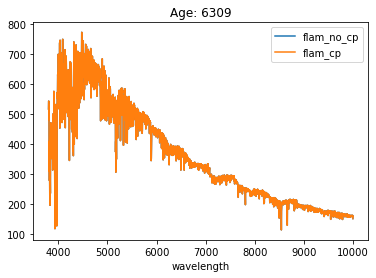

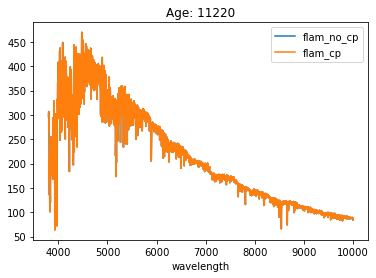

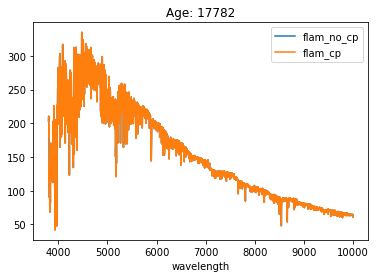

In [12]:
# Let's plot the whole spectrum for different ages to see what we're dealing with...
interesting_ages = [11, 20, 35, 63, 112, 199, 354, 
    631, 1122, 1995, 3548, 6309, 11220, 17782]
for age in interesting_ages:
    sample_and_plot_spectrum(
        pick_spectrum(
            data_set='m33_0.01',
            heavy_metal_c=790,
            age_mil=age),
        min_wavelength= 3800.0,
        max_wavelength=10000.0,
        plot_title='Age: %d' % (age))

## Plotting absorption lines

Some particular points of interest in the spectra might revolve around the absorption lines due to some element absorbing the energy at a particular wavelength. Thankfully, data on absorption lines already exists such that we can zoom into our points of interest with confidence and even calculate some other useful features from there.

### Continuum line and F-line

Note: These all will be calculated from no-cp (non-chemically peculiar) data.

Each absorption line will have some number of V-shaped dips. The horizontal line at the top of the dips is known as the 'continuum line'. In other words, it is the flux on either side of the dip which encapsulates the feature.

The F-line is the horizontal line that defines the average flux over the wavelength range of the dip which has been predetermined by the absorption table data (index band min/max).

Similar to the way the F-line is calculated, the continuum line is calculated using the red/blue min/max data in the absorption table. These have been strategically picked by astronomers to represent areas where the continuum line could be calculated from.

You will see the index band range in grey in the following graphs, as well as the blue and red continuum ranges to the left and right of the index band respectively.

### Equivalent Width

Equivalent width nicely ties up the strength of the spectral features we have been looking at into a single number. They have been calculated for each plot and added to the plot titles.

In [13]:
def get_absorption_line_data(name):
    absorption = spark.table('absorption')
    row = absorption \
        .select(
            col('index_band_min'),
            col('index_band_max'),
            col('blue_continuum_min'),
            col('blue_continuum_max'),
            col('red_continuum_min'),
            col('red_continuum_max')) \
        .filter(col('name') == name) \
        .first()
    return row.asDict()

def find_f_continuum_no_cp(spectrum, absorption_data):
    row = spectrum \
        .select(
            col('flam')) \
        .filter(
            (col('is_cp') == 0) &
                (
                    ((col('wavelength') >= absorption_data['blue_continuum_min']) &
                        (col('wavelength') <= absorption_data['blue_continuum_max'])) |
                    ((col('wavelength') >= absorption_data['red_continuum_min']) &
                        (col('wavelength') <= absorption_data['red_continuum_max']))
                )) \
        .agg(avg(col('flam')).alias('avg_flam')) \
        .select(col('avg_flam')) \
        .first()
    return row.asDict()['avg_flam']

def find_f_line_no_cp(spectrum, absorption_data):
    row = spectrum \
        .select(
                col('flam')) \
        .filter(
            (col('is_cp') == 0) &
                (col('wavelength') >= absorption_data['index_band_min']) &
                (col('wavelength') <= absorption_data['index_band_max'])) \
        .agg(avg(col('flam')).alias('avg_flam')) \
        .select(col('avg_flam')) \
        .first()
    return row.asDict()['avg_flam']

def calc_equivalent_width(f_cont, f_line, delta_index_band):
    return (f_cont - f_line) / f_cont * delta_index_band

def plot_absorption_line(spectrum, line_name, plot_title='Plot'):
    line_data = get_absorption_line_data(line_name)
    
    f_cont = find_f_continuum_no_cp(spectrum, line_data)
    f_line = find_f_line_no_cp(spectrum, line_data)
    
    ew = calc_equivalent_width(f_cont, f_line, line_data['index_band_max']-line_data['index_band_min'])
    
    sample_and_plot_spectrum(
        spectrum,
        min_wavelength=line_data['blue_continuum_min'] - 20,
        max_wavelength=line_data['red_continuum_max'] + 20,
        plot_title='%s, Equivalent width: %f' % (plot_title, ew))

    ax = plt.gca()
    ax.axhline(y=f_cont, color='grey', linestyle='--', label='f_cont_no_cp')
    ax.axhline(y=f_line, color='black', linestyle='--', label='f_line_no_cp')
    ax.axvspan(line_data['index_band_min'], line_data['index_band_max'], alpha=0.1, color='black')
    ax.axvspan(line_data['blue_continuum_min'], line_data['blue_continuum_max'], alpha=0.1, color='blue')
    ax.axvspan(line_data['red_continuum_min'], line_data['red_continuum_max'], alpha=0.1, color='red')
    ax.legend()

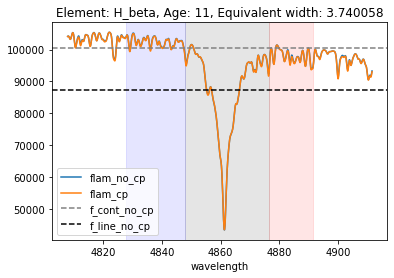

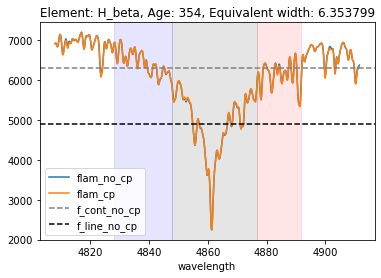

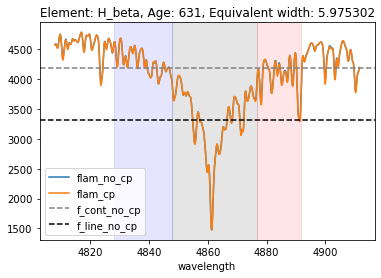

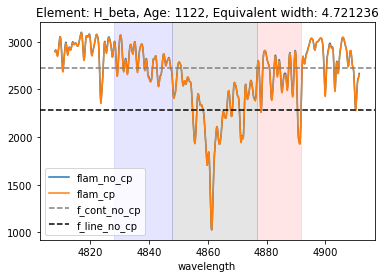

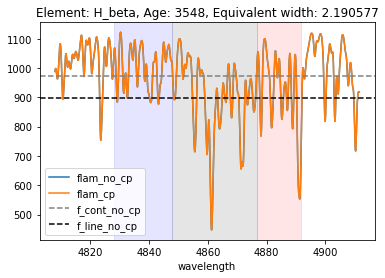

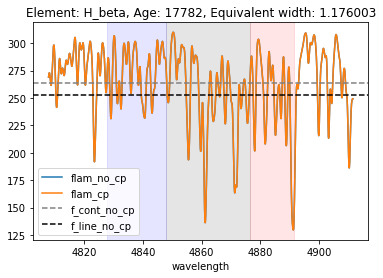

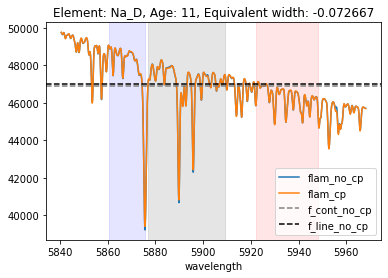

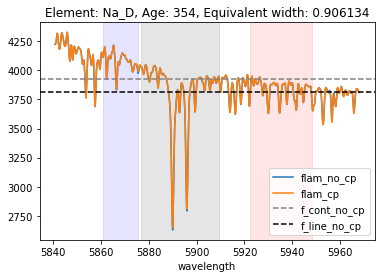

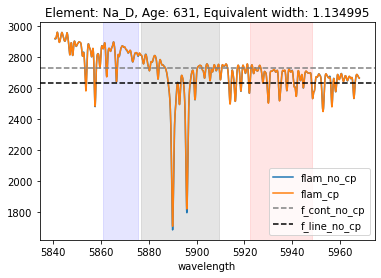

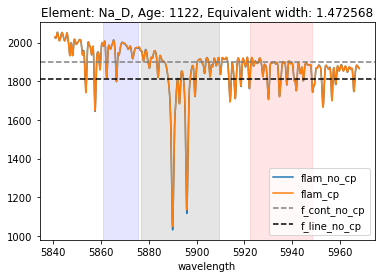

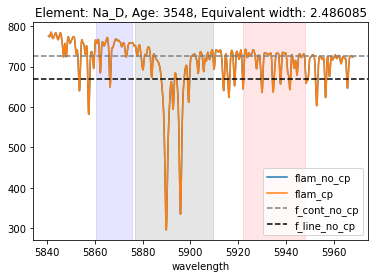

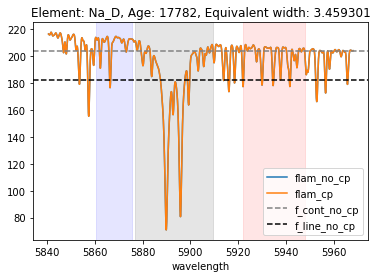

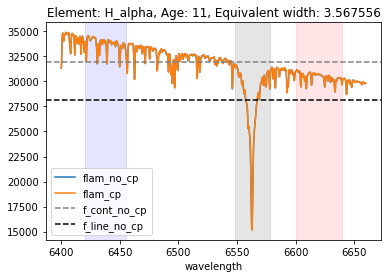

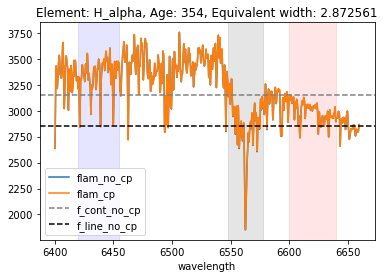

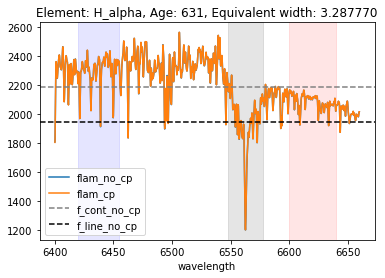

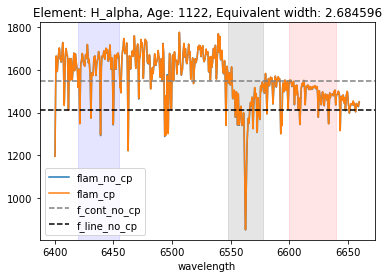

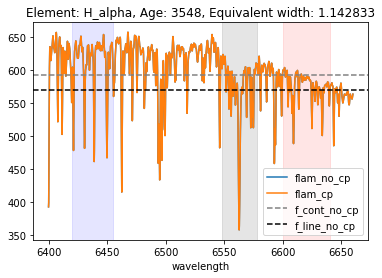

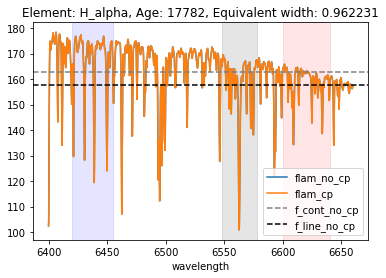

In [14]:
# Let's look at the hydrogen absorption line...
interesting_elements= ['H_beta', 'Na_D', 'H_alpha']
interesting_ages = [11, 354, 631, 1122, 3548, 17782]
for element in interesting_elements:
    for age in interesting_ages:
        plot_absorption_line(
            pick_spectrum(
                data_set='m33_0.01',
                heavy_metal_c=790,
                age_mil=age
            ),
            element,
            plot_title='Element: %s, Age: %d' % (element, age))

## Plotting Chemical Peculiarity

cp/no-cp refers to chemically peculiar or non-chemically peculiar respectively. On the previous plots, we've included both flam_no_cp and flam_cp as seperate lines, but they have been so close together we can hardly see it. However, if we zoom way in, we will see places where it differs. These next plots intend to highlight the differences by measuring the cp to no-cp ratio.

You may notice in the older ages that the cp/no-cp ratio is always 1. This is expected and implies that later ages can never be chemically peculiar.

Now, the idea here is that IF we can accurately determine chemical peculiarity from a spectrum, we might be able to get a better handle on the age as well to predict the age.

In [15]:
def measure_cp_ratio(sampled_df):
    return sampled_df \
        .select(
            col('wavelength'),
            col('flam_no_cp'),
            col('flam_cp'),
            (col('flam_cp')/col('flam_no_cp')).alias('cp_nocp_ratio'))

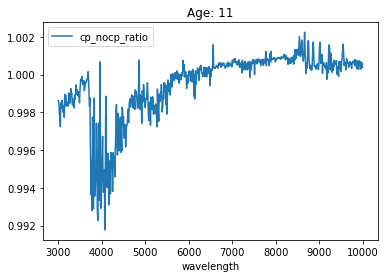

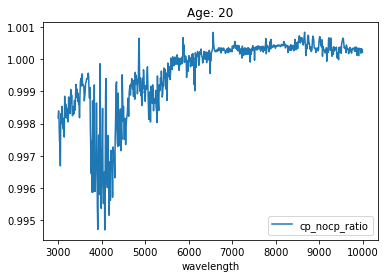

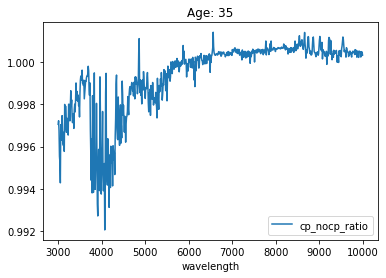

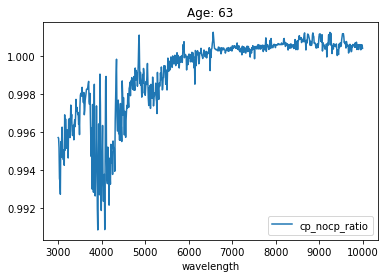

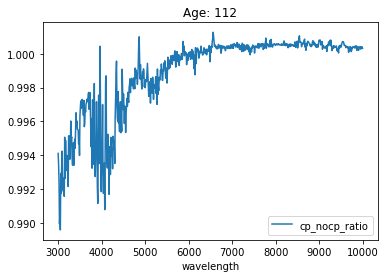

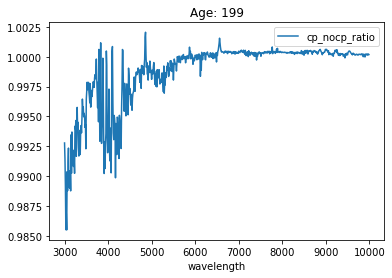

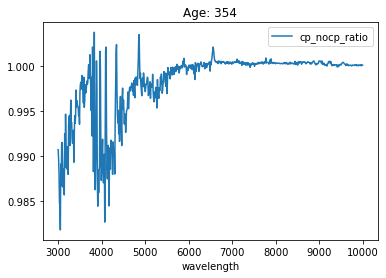

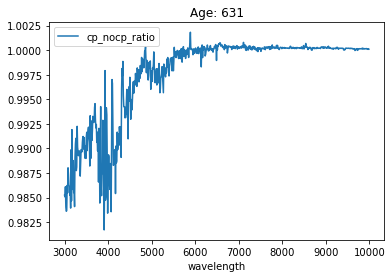

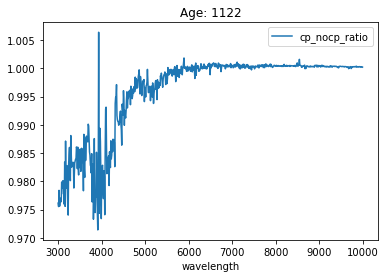

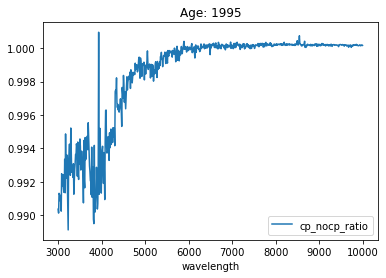

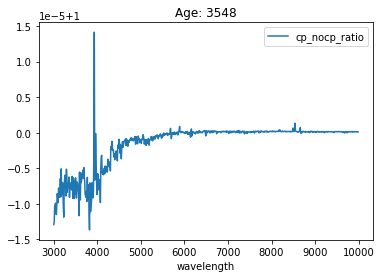

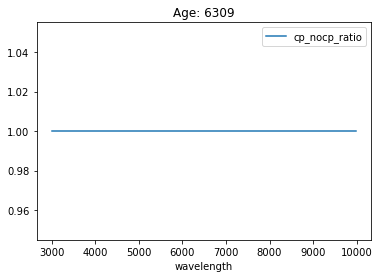

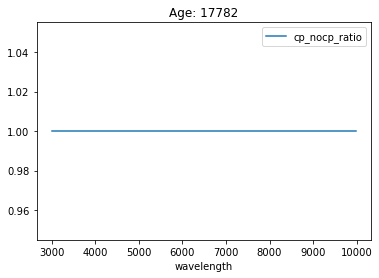

In [16]:
interesting_ages = [11, 20, 35, 63, 112, 199, 354, 
    631, 1122, 1995, 3548, 6309, 17782]
for age in interesting_ages:
    sample_df = sample_spectrum(
        pick_spectrum(
            data_set='m33_0.01',
            heavy_metal_c=790,
            age_mil=age),
        wavelength_increment=10.0,
        min_wavelength=3000.0,
        max_wavelength=10000.0)

    cp_ratio = measure_cp_ratio(sample_df).select(col('wavelength'), col('cp_nocp_ratio'))
    plot_sampled_spectrum(cp_ratio, plot_title='Age: %d' % (age))